# Hypothesis Statement
Teams with stronger contributions from bench and role players achieve higher end-of-season standings through efficient offensive and defensive contributions overall team impact compared to teams that rely on high-usage or less experienced players.


# Season Exclusions
Excluding the 2020 & 2021 Seasons due to covid and seasons being shortened.

# Defining Player Roles
Starters are recognized by: Starting 50% or more of games played and averaged 24.5 mpg or more.

Role Players are recognized by: Starting less than 50% of games played, played atleast 30 games and averaged atleast 15 mpg.

Bench Players are by: Having played atleast 15 games.

In [4]:
# Library Imports
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

In [5]:
# Load Datasets
advanced = pd.read_csv("Data/Raw/Advanced.csv")
per_game = pd.read_csv('Data/Raw/Player Per Game.csv')
team_summaries = pd.read_csv('Data/Raw/Team Summaries.csv')
career_info = pd.read_csv('Data/Raw/Player Career Info.csv')

In [16]:
# Data Cleaning and Preparation

# Filtering out:
# - Non-NBA leagues
# - Seasons before 2000 and the 2020 & 2021 seasons
# - Non-seasonal/team entries (e.g., League Leaders, All-Star teams)

advanced_df_sub = deepcopy(advanced.loc[(advanced['lg'] == 'NBA') & (advanced['season'] >= 2000) & ~advanced['season'].isin([2020, 2021]) & ~(advanced['team'] == '2TM')])
ppg_df_sub = deepcopy(per_game.loc[(per_game['lg'] == 'NBA') & (per_game['season'] >= 2000) & ~per_game['season'].isin([2020, 2021]) & ~(per_game['team'] == '2TM')])
ts_df_sub = deepcopy(team_summaries.loc[(team_summaries['lg'] == 'NBA') & (team_summaries['season'] >= 2000) & ~team_summaries['season'].isin([2020, 2021]) & ~(team_summaries['abbreviation'] == '2TM') & ~(team_summaries['team'] == 'League Average')])

# Standardize team abbreviation column names by renaming to 'abv'

advanced_df_sub = advanced_df_sub.rename(columns={"team": "abv"})
ppg_df_sub = ppg_df_sub.rename(columns={"team":"abv"})
ts_df_sub = ts_df_sub.rename(columns={"abbreviation":"abv"})

# Converting columns to correct data type.

ppg_df_sub['gs'] = ppg_df_sub['gs'].astype(int)
ts_df_sub['w'] = ts_df_sub['w'].astype(int)
ts_df_sub['l'] = ts_df_sub['l'].astype(int)

# Populate NaN values with 0 for the following columns as they are percentage fields that did no get calcualted due to the
# the fields they are calculated from are 0. 
# Columns being set to 0: fg_percent, x3p_percent, x2p_percent, e_fg_percent, ft_percent
# ppg_df_sub.isna().sum()  

ppg_df_sub = ppg_df_sub.fillna(0)

# Combine nessecary states from team summary, advanced, and per-game stats into a single DataFrame for insights

# Select only the needed columns from each DataFrame
advanced_cols = ["season", "player_id", "abv", "per", "ts_percent", "obpm", "dbpm", "usg_percent", "gs", "g"]
ppg_cols = ["season", "player_id", "abv", "ast_per_game", "tov_per_game", "mp_per_game"]
ts_cols = ["season", "abv", "w", "l", "playoffs"]

# Merge DataFrames
player_stats_DF = (
    advanced_df_sub[advanced_cols]
    .merge(ppg_df_sub[ppg_cols], on=["season", "player_id", "abv"], how="inner")
    .merge(ts_df_sub[ts_cols], on=["season", "abv"], how="inner")
)

# Rounding pecents to 2 decimal places.
player_stats_DF["per"] = player_stats_DF["per"].round(2)
player_stats_DF["ts_percent"] = player_stats_DF["ts_percent"].round(2)
player_stats_DF["obpm"] = player_stats_DF["obpm"].round(2)
player_stats_DF["dbpm"] = player_stats_DF["dbpm"].round(2)

# Calculate key player metrics:

# - 'a2t_perc': Assist-to-turnover ratio, set to 0 if AST or TO is 0
player_stats_DF["a2t_perc"] = np.where(
    (player_stats_DF["ast_per_game"] == 0) | (player_stats_DF["tov_per_game"] == 0),
    0,
    (player_stats_DF["ast_per_game"] / player_stats_DF["tov_per_game"]).round(2)
)

# - 'team_win_perc': Team win percentage while player was on the team
player_stats_DF["team_win_perc"] = (player_stats_DF["w"] / (player_stats_DF["w"] + player_stats_DF["l"])).round(2)

# - 'Role': Classify player as Starter ('S'), Role player ('R'), Bench ('B'), Insignificant ('I')
#   based on games started, total games played, and minutes per game
player_stats_DF["role"] = np.select(
    [
        (player_stats_DF["gs"] / player_stats_DF["g"] >= 0.5) & (player_stats_DF["mp_per_game"] >= 24.5),
        (player_stats_DF["g"] >= 30) & (player_stats_DF["gs"] / player_stats_DF["g"] < 0.5) & (player_stats_DF["mp_per_game"] >= 15),
        (player_stats_DF["g"] >= 15) & (player_stats_DF["mp_per_game"] < 24.5),
    ],
    ["S", "R", "B"],
    default="I"
)

# Merge 'from' (Year of First Season) from career_info on player_id
player_stats_DF = player_stats_DF.merge(
    career_info[['player_id', 'from']], 
    on='player_id', 
    how='inner'
)
# Convert columns to int to calculate
player_stats_DF['season'] = player_stats_DF['season'].astype(int)
player_stats_DF['from'] = player_stats_DF['from'].astype(int)

# Calculate experience as the number of seasons played
player_stats_DF['experience'] = player_stats_DF['season'] - player_stats_DF['from']

# Drop the 'from' column as it's no longer needed
player_stats_DF = player_stats_DF.drop(columns=['from'])

# Remove players with insignificant game time
# These are marked with Role 'I' in player_stats_DF
player_stats_DF = player_stats_DF[player_stats_DF["role"] != "I"]

# **Insight #1: Defensive Metrics and How They Support Team Success**

Goal: Show if teams with better defensive performance, particularly from bench role players, better end-of-season standings, emphasizing the defensive contributions of “quiet stars.”

DBPM (Defensive Box Plus-Minus) is a statistic that measures a player's defensive impact per 100 possessions in basketball. A higher DBPM means a player contributes more to their team's defense, like preventing opponents from scoring.

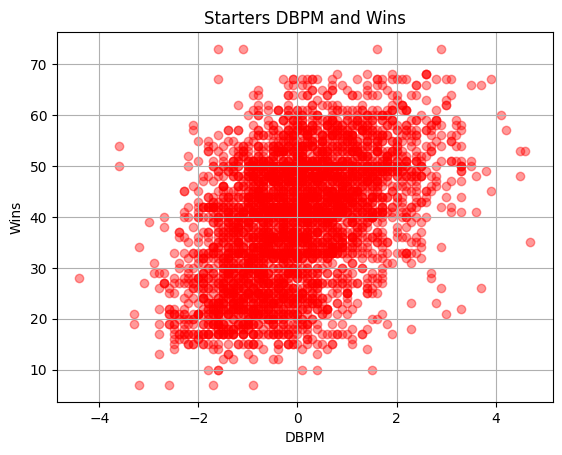

In [17]:
# Starters
plt.scatter(player_stats_DF.loc[player_stats_DF["role"] == "S", "dbpm"],
            player_stats_DF.loc[player_stats_DF["role"] == "S", "w"], 
            color='Red', 
            alpha=0.4)
plt.title('Starters DBPM and Wins')
plt.xlabel('DBPM')
plt.ylabel('Wins')

plt.grid(True)
plt.show()

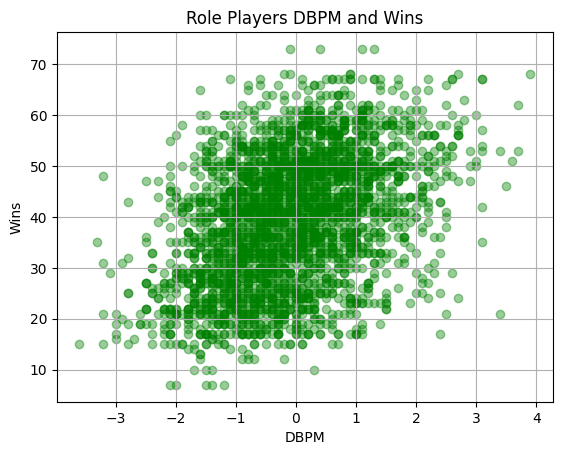

In [18]:
# Role Players
plt.scatter(player_stats_DF.loc[player_stats_DF["role"] == "R", "dbpm"],
            player_stats_DF.loc[player_stats_DF["role"] == "R", "w"], 
            color='green', 
            alpha=0.4)
plt.title('Role Players DBPM and Wins')
plt.xlabel('DBPM')
plt.ylabel('Wins')

plt.grid(True)
plt.show()

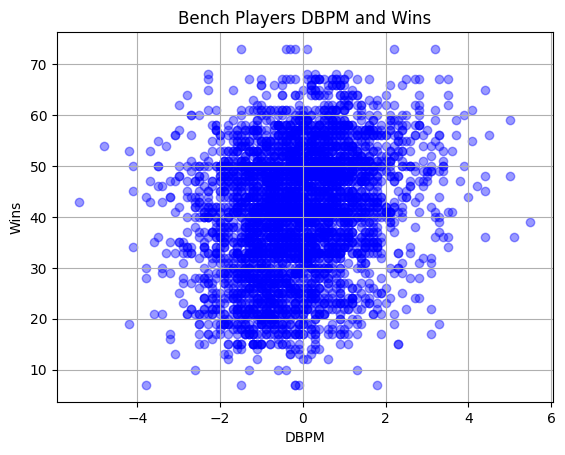

In [19]:
# Bench Players
plt.scatter(player_stats_DF.loc[player_stats_DF["role"] == "B", "dbpm"],
            player_stats_DF.loc[player_stats_DF["role"] == "B", "w"], 
            color='blue', 
            alpha=0.4)
plt.title('Bench Players DBPM and Wins')

plt.xlabel('DBPM')
plt.ylabel('Wins')

plt.grid(True)
plt.show()

# Insight #2: Role Player Efficiency and How It Supports Team Success

Goal: Show that teams with more efficient role players have higher win percentages, emphasizing the efficiency of “quiet stars” in offensive and defensive contributions.

Player Effiency Rating (PER) is a per-minute rating that quantifies a player's performance by combining various box score statistics, such as points, rebounds, assists, steals, blocks, turnovers, and shooting efficiency, into a single value. It is normalized so that the league average PER is 15.0, with higher values indicating better performance.

In [20]:
# Getting role players
role_players = player_stats_DF[player_stats_DF["role"] == "R"]

# Aggregate role player stats by team and season
role_player_stats = role_players.groupby(['season', 'abv'])[['playoffs', 'per', 'obpm', 'dbpm', 'team_win_perc']].mean().reset_index()

role_player_stats.columns = ['season', 'team', 'playoffs', 'per', 'obpm', 'dbpm', 'team_win_perc']

role_player_stats["per"] = role_player_stats["per"].round(2)
role_player_stats["obpm"] = role_player_stats["obpm"].round(2)
role_player_stats["dbpm"] = role_player_stats["dbpm"].round(2)

# Filter for 2023-24 season
#role_player_stats_playoffs = role_player_stats[role_player_stats['season'] == 2023]
#role_player_stats_no_playoffs = role_player_stats[role_player_stats['season'] == 2023]
#playoff_teams = role_player_stats[(role_player_stats['team_win_perc'] >= .6) & (role_player_stats['season'] == 2025)]
#non_playoff_teams = role_player_stats[(role_player_stats['team_win_perc'] < .6) & (role_player_stats['season'] == 2025)]

# Sort by season + win percentage
sorted_df = role_player_stats.sort_values(["season", "team_win_perc"], ascending=[True, False])

# Rank teams within each season
sorted_df["rank"] = sorted_df.groupby("season")["team_win_perc"].rank(method="first", ascending=False)

# Count teams per season
team_counts = sorted_df.groupby("season")["team_win_perc"].transform("count")

# Split into top half and bottom half
top_half = sorted_df[sorted_df["rank"] <= team_counts / 2].copy()
bottom_half = sorted_df[sorted_df["rank"] > team_counts / 2].copy()


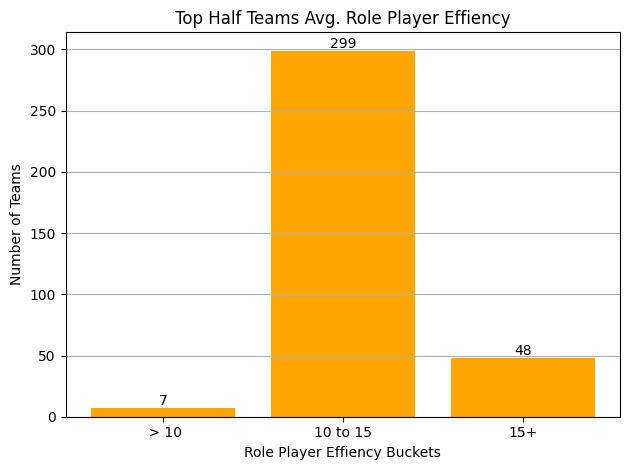

In [21]:

# Create PER buckets
bins = [0, 10, 15, 20]  # adjust ranges as needed
labels = [" > 10","10 to 15", "15+"]

# Safe assignment with .loc
top_half.loc[:, "per_bucket"] = pd.cut(top_half["per"], bins=bins, labels=labels)

# Count teams per bucket
bucketed = top_half.groupby("per_bucket", observed=True).size().reset_index(name="team_count")

# Plot with labels
fig, ax = plt.subplots()
bars = ax.bar(bucketed["per_bucket"], bucketed["team_count"], color="orange")

ax.set_title("Top Half Teams Avg. Role Player Effiency")
ax.set_xlabel("Role Player Effiency Buckets")
ax.set_ylabel("Number of Teams")
ax.bar_label(bars, fmt='{:,.0f}')

plt.tight_layout()
plt.grid(axis="y")
plt.show()

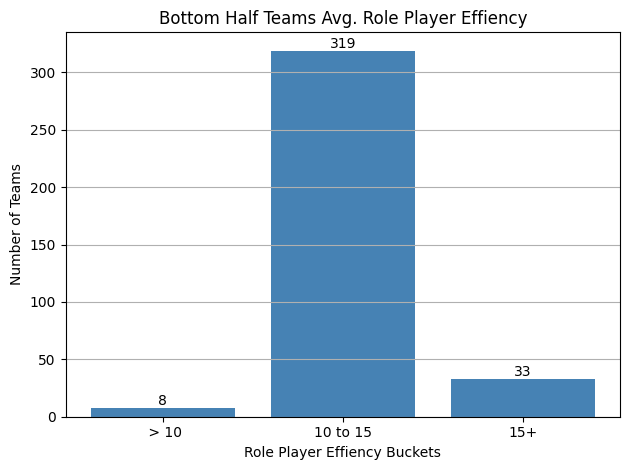

In [22]:
# Create PER buckets
bins = [0, 10, 15, 20]  # adjust ranges as needed
labels = [" > 10","10 to 15", "15+"]

# Safe assignment with .loc
bottom_half.loc[:, "per_bucket"] = pd.cut(bottom_half["per"], bins=bins, labels=labels)

# Count teams per bucket
bucketed = bottom_half.groupby("per_bucket", observed=True).size().reset_index(name="team_count")

# Plot with labels
fig, ax = plt.subplots()
bars = ax.bar(bucketed["per_bucket"], bucketed["team_count"], color="steelblue")

ax.set_title("Bottom Half Teams Avg. Role Player Effiency")
ax.set_xlabel("Role Player Effiency Buckets")
ax.set_ylabel("Number of Teams")
ax.bar_label(bars, fmt='{:,.0f}')

plt.tight_layout()
plt.grid(axis="y")
plt.show()

# Insight #3: Player Efficiency and Its Correlation to Experience

Goal: Quantify how veteran NBA players with 7+ years of experience demonstrate higher efficiency compared to less experienced players, highlighting their value to team success through optimized roles and production.

In [23]:
player_stats_DF.head()

,season,player_id,abv,per,ts_percent,obpm,dbpm,usg_percent,gs,g,ast_per_game,tov_per_game,mp_per_game,w,l,playoffs,a2t_perc,team_win_perc,role,experience
0,2025,achiupr01,NYK,13.6,0.53,-2.1,0.2,14.9,10.0,57,1.0,0.8,20.5,51,31,True,1.25,0.62,R,4
1,2025,adamsst01,HOU,16.6,0.54,0.0,0.3,13.6,3.0,58,1.1,0.9,13.7,52,30,True,1.22,0.63,B,11
2,2025,adebaba01,MIA,18.9,0.56,1.0,1.0,23.5,78.0,78,4.3,2.1,34.3,37,45,True,2.05,0.45,S,7
3,2025,agbajoc01,TOR,12.0,0.60,-0.9,0.2,14.6,45.0,64,1.5,0.8,27.2,30,52,False,1.88,0.37,S,2
4,2025,aldamsa01,MEM,16.8,0.59,2.5,0.7,18.5,16.0,65,2.9,1.1,25.5,48,34,True,2.64,0.59,R,3
